In [234]:
import warnings
import itertools
import pandas as pd
import plotting as mp
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [235]:
project_name = 'project_5526'
filelocation='../../capstone_data/Azimuth/clean/{}_featurized.csv'.format(project_name)
df = pd.read_csv(filelocation)
df['t'] = pd.to_datetime(df['t'], format='%Y-%m-%d %H:%M:%S')
df.set_index('t',inplace=True)

In [236]:
df['power_1'] = df['load_v1rms'] * df['load_i1rms'] 
df['power_2'] = df['load_v2rms'] * df['load_i2rms'] 
df['power_3'] = df['load_v3rms'] * df['laod_i3rms'] 
df['power_all'] = df['power_1'] +df['power_2']+df['power_3']

In [237]:
df2 = df.loc['2017-01-10 00:00:00':]
y = pd.DataFrame(df2['power_all'])

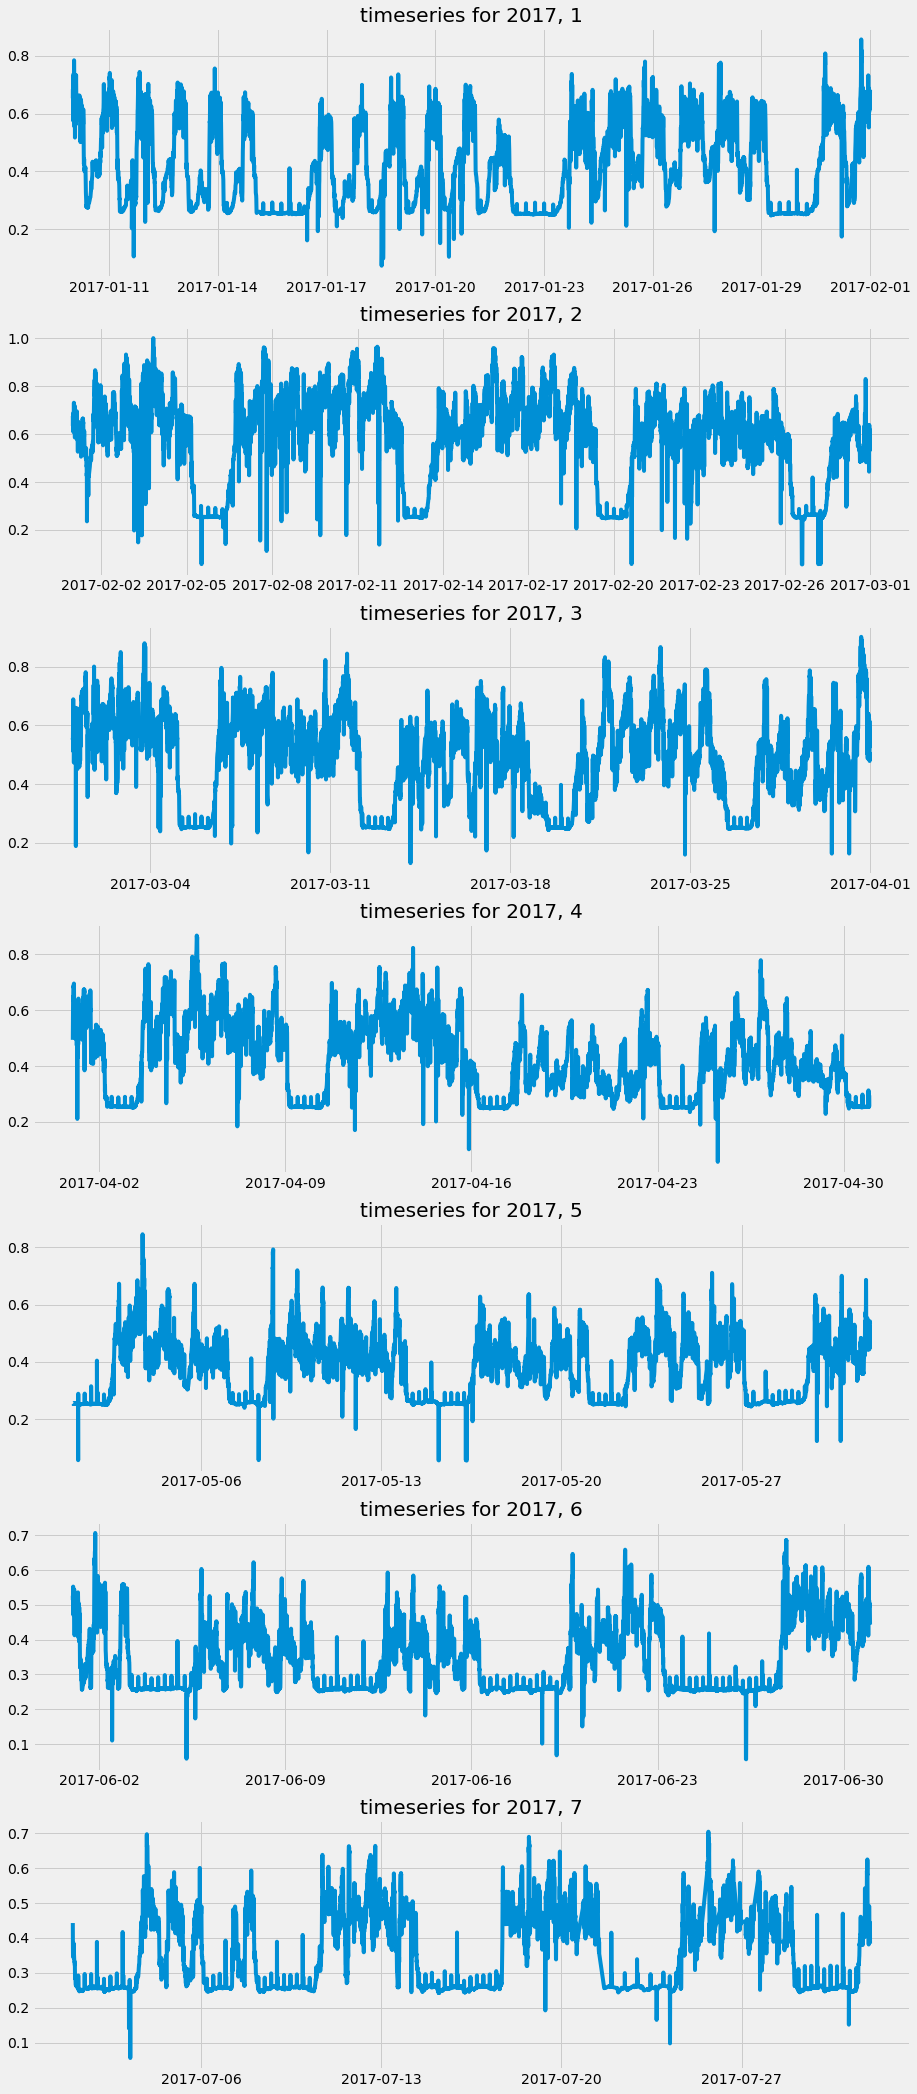

In [130]:
mp.plot_all_data(df2,['power_all'])

In [238]:
y = y['power_all'].resample('H').mean()

In [239]:
y

t
2017-01-10 00:00:00    743075.145029
2017-01-10 01:00:00    633016.837270
2017-01-10 02:00:00    710949.304384
2017-01-10 03:00:00    669372.710766
2017-01-10 04:00:00    666860.025036
2017-01-10 05:00:00    649315.695657
2017-01-10 06:00:00    641819.497723
2017-01-10 07:00:00    490450.946885
2017-01-10 08:00:00    393272.513847
2017-01-10 09:00:00    297093.689504
2017-01-10 10:00:00    306672.375457
2017-01-10 11:00:00    331768.176051
2017-01-10 12:00:00    384702.225374
2017-01-10 13:00:00    448774.105780
2017-01-10 14:00:00    454358.035562
2017-01-10 15:00:00    455928.107288
2017-01-10 16:00:00    415100.764649
2017-01-10 17:00:00    416143.374884
2017-01-10 18:00:00    509972.640502
2017-01-10 19:00:00    593986.509482
2017-01-10 20:00:00    670994.661003
2017-01-10 21:00:00    644325.886829
2017-01-10 22:00:00    671369.151352
2017-01-10 23:00:00    702271.756171
2017-01-11 00:00:00    734944.169680
2017-01-11 01:00:00    695103.609063
2017-01-11 02:00:00    708494.231103

In [132]:
y = y.fillna(y.bfill())

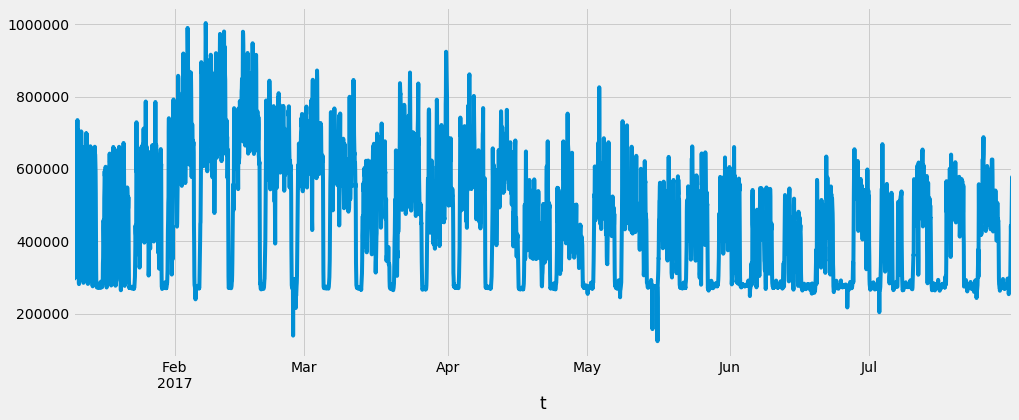

In [133]:
y.plot(figsize=(15, 6))
plt.show()

# Trend Seasonal Residual Decomposition

In [134]:
python_decomposition = sm.tsa.seasonal_decompose(y)
def plot_seasonal_decomposition(axs, series, sd):
    axs[0].plot(series.index, series)
    axs[0].set_title("Raw Series")
    axs[1].plot(series.index, sd.trend)
    axs[1].set_title("Trend Component $T_t$")
    axs[2].plot(series.index, sd.seasonal)
    axs[2].set_title("Seasonal Component $S_t$")
    axs[3].plot(series.index, sd.resid)
    axs[3].set_title("Residual Component $R_t$")

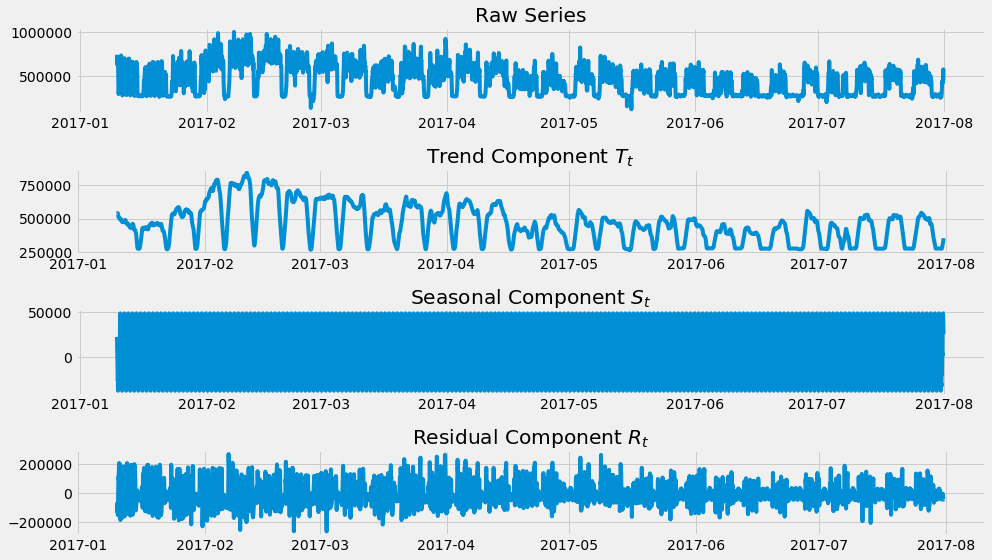

In [135]:
fig, axs = plt.subplots(4, figsize=(14, 8))
plot_seasonal_decomposition(axs, y, python_decomposition)
plt.tight_layout()
plt.show()

## Differencing

In [166]:
def plot_series_and_difference(axs, series, title):
    diff = series.diff().diff().diff().diff().diff()
    axs[0].plot(series.index, series)
    axs[0].set_title("Raw Series: {}".format(title))
    axs[1].plot(series.index, diff)
    axs[1].set_title("Series of First Differences: {}".format(title))

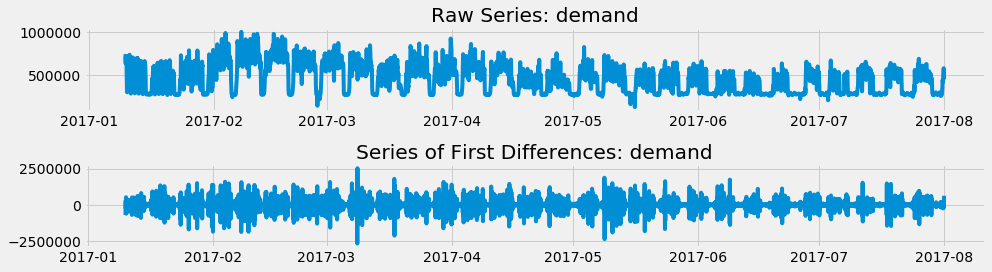

In [167]:
fig, axs = plt.subplots(2, figsize=(14, 4))
plot_series_and_difference(axs, y, 'demand')
fig.tight_layout()
plt.show()

In [159]:
test = sm.tsa.stattools.adfuller(y)
print("ADF p-value for demand series: {0:2.2f}".format(test[1]))

ADF p-value for demand series: 0.00


In [160]:
test = sm.tsa.stattools.adfuller(y.diff()[1:])
print("ADF p-value for differenced demand series: {0:2.2f}".format(test[1]))

ADF p-value for differenced demand series: 0.00


## Auto correlation plots

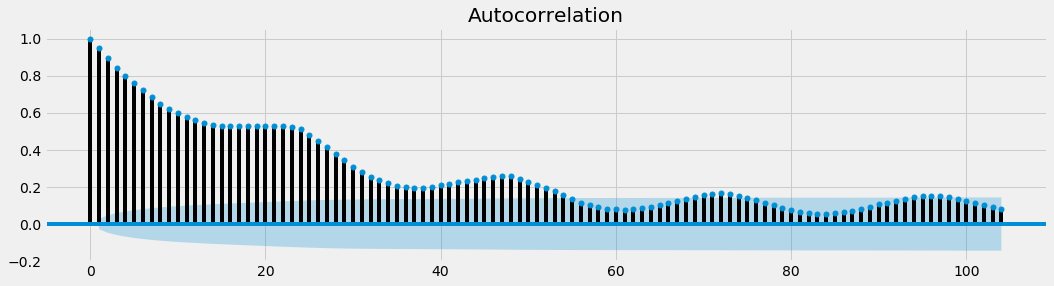

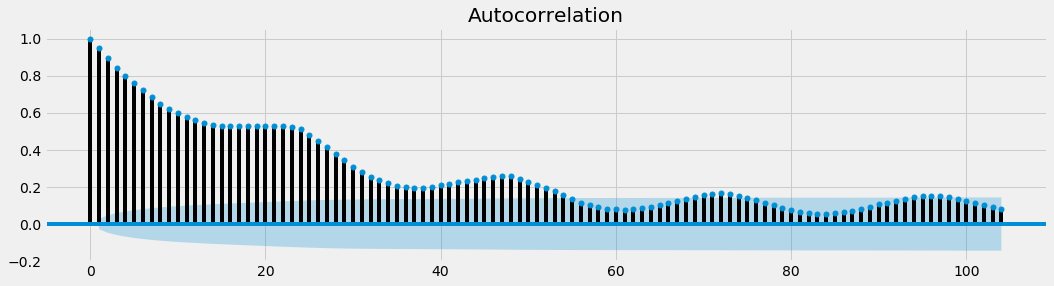

In [185]:
fig, ax = plt.subplots(1, figsize=(16, 4))

_ = sm.graphics.tsa.plot_acf(y, lags=2*52, ax=ax)

plt.show()

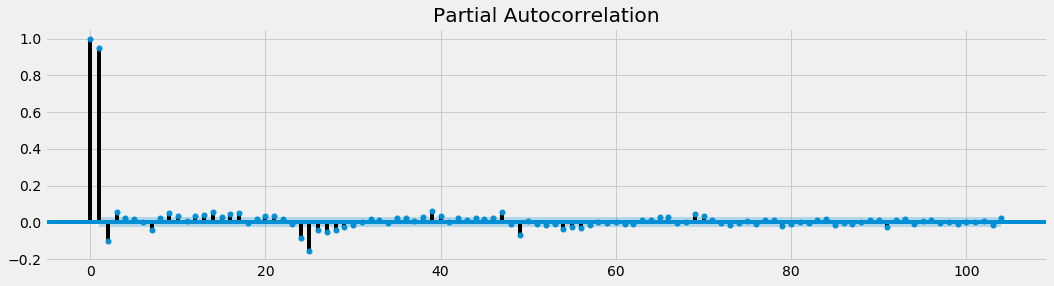

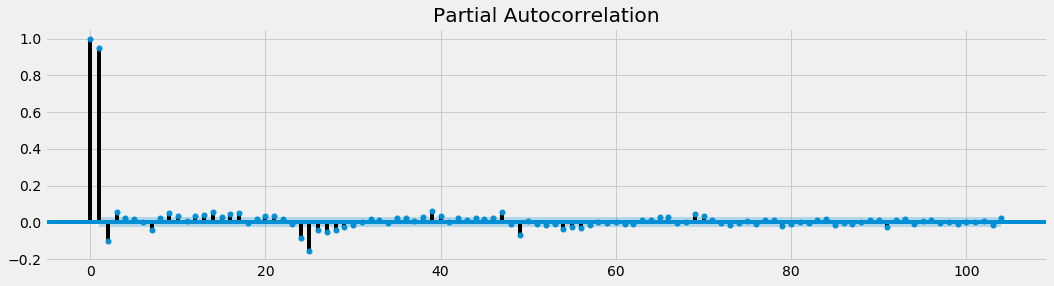

In [187]:
fig, ax = plt.subplots(1, figsize=(16, 4))
_ = sm.graphics.tsa.plot_pacf(y, lags=2*52, ax=ax)
plt.show()

In [212]:
x = pd.DataFrame(y)
x['dayofweek'] = x.index.dayofweek
x['hour'] = x.index.hour
average = x.groupby(['dayofweek','hour'])['power_all'].mean()
variance = x.groupby(['dayofweek','hour'])['power_all'].std()

,power_all,dayofweek,hour
t,,,
2017-01-10 00:00:00,743075.145029,1,0
2017-01-10 01:00:00,633016.837270,1,1
2017-01-10 02:00:00,710949.304384,1,2


In [31]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 1) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 0)
SARIMAX: (0, 0, 1) x (0, 1, 0, 0)
SARIMAX: (0, 1, 0) x (0, 1, 1, 0)
SARIMAX: (0, 1, 0) x (1, 0, 0, 0)


In [ ]:
warnings.filterwarnings("ignore") # specify to ignore warning messages
print 'number of models {}'.format(len(pdq)*len(seasonal_pdq))
for param in pdq:
    for param_seasonal in seasonal_pdq:
        print 'SARIMAX: {} x {}'.format(param, param_seasonal)
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

number of models 64
SARIMAX: (0, 0, 0) x (0, 0, 0, 2016)
SARIMAX: (0, 0, 0) x (0, 0, 1, 2016)
SARIMAX: (0, 0, 0) x (0, 1, 0, 2016)
SARIMAX: (0, 0, 0) x (0, 1, 1, 2016)
SARIMAX: (0, 0, 0) x (1, 0, 0, 2016)
SARIMAX: (0, 0, 0) x (1, 0, 1, 2016)
SARIMAX: (0, 0, 0) x (1, 1, 0, 2016)
SARIMAX: (0, 0, 0) x (1, 1, 1, 2016)


In [228]:
y

,power_all
t,
2017-01-10 00:00:00,699969.710385
2017-01-10 00:05:00,733404.761883
2017-01-10 00:10:00,656486.026031
2017-01-10 00:15:00,616784.406107
2017-01-10 00:20:00,738247.631157
2017-01-10 00:25:00,789286.292210
2017-01-10 00:30:00,787160.678606
2017-01-10 00:35:00,729880.897131
2017-01-10 00:40:00,707020.426964


In [229]:
params = (1,1,0)
seasonal_params = (0,1,0,24)
mod = sm.tsa.statespace.SARIMAX(y,order=params,seasonal_order=seasonal_params,
                                enforce_stationarity=False,enforce_invertibility=False)
results = mod.fit()
print('ARIMA{}x{}2016 - AIC:{}'.format(params, seasonal_params, results.aic))

ARIMA(1, 1, 0)x(0, 1, 0, 24)2016 - AIC:1421484.62992


In [230]:
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1275      0.002    -66.820      0.000      -0.131      -0.124
sigma2      2.858e+09   3.25e-14    8.8e+22      0.000    2.86e+09    2.86e+09


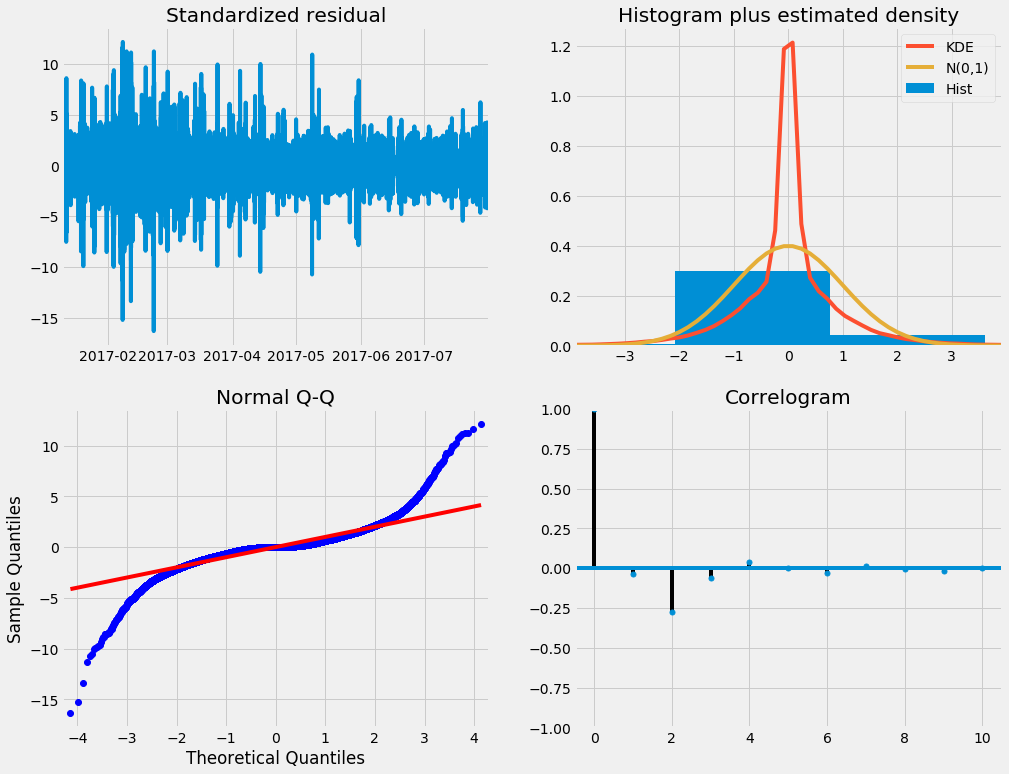

In [231]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [232]:
pred = results.get_prediction(start=pd.to_datetime('2017-07-15'), dynamic=False)
pred_ci = pred.conf_int()

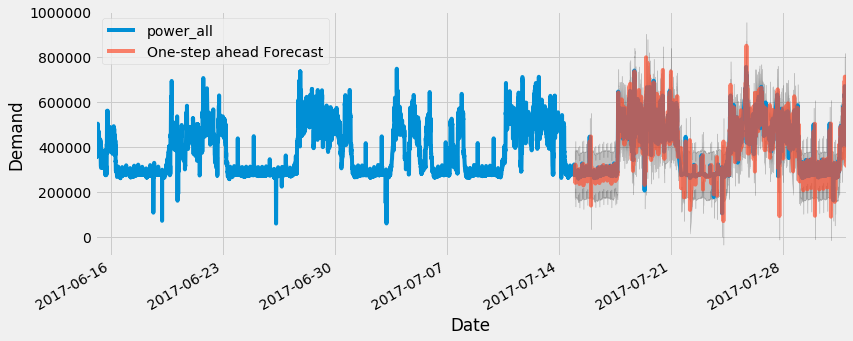

In [233]:

ax = y['2017-06-15 00:00:00':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(12,5))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Demand')
plt.legend()

plt.show()

In [207]:
y_forecasted = pred.predicted_mean
y_truth = y['2017-07-15':]

# Compute the mean square error
rmse = np.sqrt(((y_forecasted - y_truth) ** 2).mean())
print('The Mean Squared Error of our forecasts is {}'.format(round(rmse, 2)))

The Mean Squared Error of our forecasts is 36653.21


In [208]:
pred_dynamic = results.get_prediction(start=pd.to_datetime('2017-07-15'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

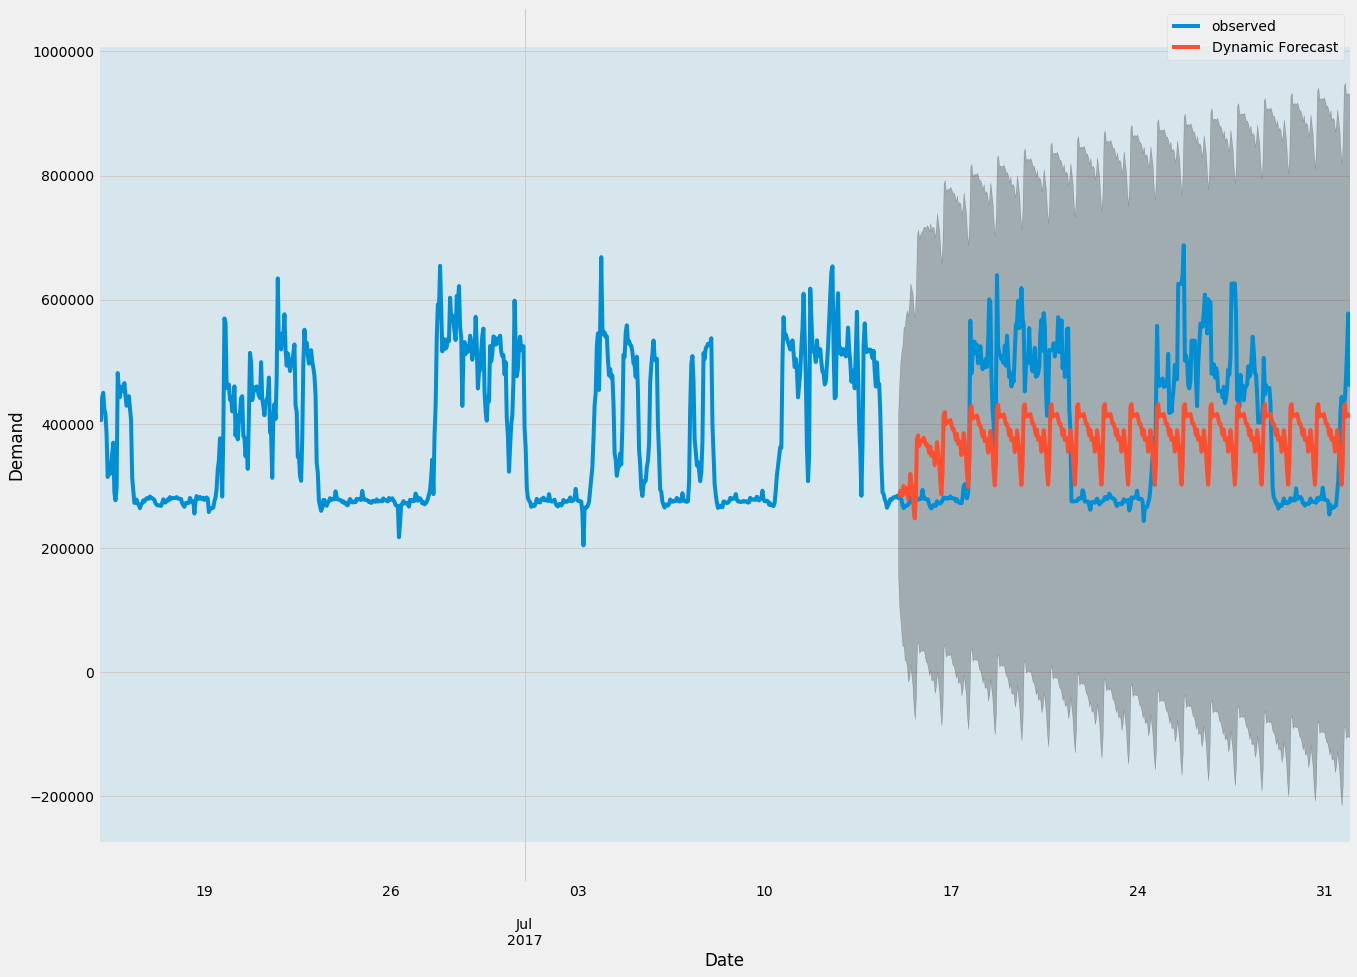

In [209]:
ax = y['2017-06-15 00:00:00':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2017-06-15'), y.index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Demand')

plt.legend()
plt.show()